<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Deep IV: Use Case and Examples

Deep IV uses deep neural networks in a two-stage instrumental variable (IV) estimation of causal effects, as described in [this ICML publication](http://proceedings.mlr.press/v70/hartford17a/hartford17a.pdf) or in the `econml` [specification](https://econml.azurewebsites.net/spec/estimation/iv.html#deep-instrumental-variables).  In the EconML SDK, we have implemented Deep IV estimation on top of the Keras framework for building and training neural networks.  In this notebook, we'll demonstrate how to use the SDK to apply Deep IV to synthetic data.

### Data

Deep IV works in settings where we have several different types of observations:
* Covariates, which we will denote with `X`
* Instruments, which we will denote with `Z`
* Treatments, which we will denote with `T`
* Responses, which we will denote with `Y`

The main requirement is that `Z` is a set of valid instruments; in particular `Z` should affect the responses `Y` only through the treatments `T`.  We assume that `Y` is an arbitrary function of `T` and `X`, plus an additive error term, and that `T` is an arbitrary function of `Z` and `X`.  Deep IV then allows us to estimate `Y` given `T` and `X`.

### Estimation

To do this, the Deep IV estimator uses a two-stage approach that involves solving two subproblems:
1. It estimates the *distribution* of the treatment `T` given `Z` and `X`, using a mixture density network.
2. It estimates the dependence of the response `Y` on `T` and `X`.

Both of these estimates are performed using neural networks.  See the paper for a more complete description of the setup and estimation approach.

### Using the SDK

In the `econml` package, our Deep IV estimator is built on top of the Keras framework; we support either the Tensorflow or the Theano backends.  There are three steps to using the `DeepIVEstimator`:

1. Construct an instance.  
    * The `m` and `h` arguments to the initializer specify deep neural network models for estimating `T` and `Y` as described above.  They are each *functions* that take two Keras inputs and return a Keras model (the inputs are `z` and `x` in the case of `m` and the output's shape should match `t`'s; the inputs are `t` and `x` in the case of `h` and the output's shape should match `y`'s).  Note that the `h` function will be called multiple times, but should reuse the same weights - see below for a concrete example of how to achieve this using the Keras API.
    * The `n_samples`, `use_upper_bound_loss`, and `n_gradient_samples` arguments together determine how the loss for the response model will be computed.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is zero, then `n_samples` samples will be averaged to approximate the response - this will provide an unbiased estimate of the correct loss only in the limit as the number of samples goes to infinity.
        * If `use_upper_bound_loss` is `False` and `n_gradient_samples` is nonzero, then we will average `n_samples` samples to approximate the response a first time and average `n_gradient_samples` samples to approximate it a second time - combining these allows us to provide an unbiased estimate of the true loss.
        * If `use_upper_bound_loss` is `True`, then `n_gradient_samples` must be `0`; `n_samples` samples will be used to get an unbiased estimate of an upper bound of the true loss - this is equivalent to adding a regularization term penalizing the variance of the response model (see the `econml` specification linked above for a derivation of this fact).
2. Call `fit` with training samples of `Y`, `T`, `X`, and `Z`; this will train both sub-models.
3. Call `effect` or `predict` depending on what output you want.  `effect` calculates the difference in outcomes based on the features and two different treatments, while `predict` predicts the outcome based on a single treatment.

The remainder of this notebook will walk through a concete example.

In [1]:
from econml.deepiv import DeepIVEstimator
from econml.bootstrap import BootstrapEstimator
import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Synthetic data

To demonstrate the Deep IV approach, we'll construct a syntetic dataset obeying the requirements set out above.  In this case, we'll take `X`, `Z`, `T`, and `Y` to come from the following distribution: 

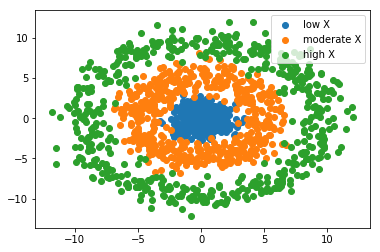

In [2]:
n = 5000

x = np.random.uniform(low=0.0, high=10.0, size=(n,1))
theta = np.random.uniform(low=0.0, high=2 * np.pi, size=(n,1))
z = x * np.cos(theta) + np.random.normal(size=(n,1))
t = x * np.sin(theta) + np.random.normal(size=(n,1))
y = t * t - x * x + np.random.normal(size=(n,1))

plt.scatter(z[x < 1], t[x < 1], label='low X')
plt.scatter(z[(x > 4.5) * (x < 5.5)], t[(x > 4.5) * (x < 5.5)], label='moderate X')
plt.scatter(z[x > 9], t[x > 9], label='high X')
plt.legend()
plt.show()

Here, we'll imagine that `Z` and `X` are causally affecting `T`; as you can see in the plot above, low or high values of `Z` drive moderate values of `T` and moderate values of `Z` cause `T` to have a bi-modal distribution when `X` is high, but a unimodal distribution centered on 0 when `X` is low.  `Y` is a non-linear function of `T` and `X` with no direct dependence on `Z` plus additive noise (as required).  We want to estimate the effect of particular `T` and `X` values on `Y`.

## Defining the neural network models

Now we'll define simple treatment and response models using the Keras `Sequential` model built up of a series of layers.  Each model with have an `input_shape` of 2 (to match the sums of the dimensions of `X` plus `Z` in the treatment case and `T` plus `X` in the response case).

In [3]:
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])

response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(64, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(32, activation='relu'),
                                   keras.layers.Dropout(0.17),
                                   keras.layers.Dense(1)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we'll instantiate the `DeepIVEstimator` class using these models.  Defining the response model *outside* of the lambda passed into constructor is important, because (depending on the settings for the loss) it can be used multiple times in the second stage and we want the same weights to be used every time.

In [4]:
deepIvEst = DeepIVEstimator(n_components = 10, # number of gaussians in our mixture density network
                            m = lambda z, x : treatment_model(keras.layers.concatenate([z,x])), # treatment model
                            h = lambda t, x : response_model(keras.layers.concatenate([t,x])),  # response model
                            n_samples = 1, # number of samples to use to estimate the response
                            use_upper_bound_loss = False, # whether to use an approximation to the true loss
                            n_gradient_samples = 1, # number of samples to use in second estimate of the response (to make loss estimate unbiased)
                            optimizer='adam', # Keras optimizer to use for training - see https://keras.io/optimizers/ 
                            s1=100, # number of epochs to train treatment model
                            s2=100) # number of epochs to train response model

## Fitting and predicting using the model
Now we can fit our model to the data:

And now we can create a new set of data and see whether our predicted effect matches the true effect `T*T-X*X`:

In [5]:
boot_est = BootstrapEstimator(deepIvEst, n_bootstrap_samples=10, n_jobs=1)

In [6]:
boot_est.fit(Y=y,T=t,X=x,Z=z)

Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/100
5000/5000 [==============================] - 1s 127us/step - loss: 1.8754
Epoch 2/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.6490
Epoch 3/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.5207
Epoch 4/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.4825: 0s - loss: 1.49
Epoch 5/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.4534
Epoch 6/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.4326
Epoch 7/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.4202
Epoch 8/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.4137
Epoch 9/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.3915
Epoch 10/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.3914
Epoch 11/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.3765
Epoch 12/100
5000/5000 [=====================

5000/5000 [==============================] - 0s 40us/step - loss: 1.2688
Epoch 97/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.2677
Epoch 98/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.2667
Epoch 99/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.2715
Epoch 100/100
5000/5000 [==============================] - 0s 40us/step - loss: 1.2625
Epoch 1/100
5000/5000 [==============================] - 1s 286us/step - loss: 411.8112
Epoch 2/100
5000/5000 [==============================] - 0s 78us/step - loss: 351.1319
Epoch 3/100
5000/5000 [==============================] - 0s 77us/step - loss: 358.5257
Epoch 4/100
5000/5000 [==============================] - 0s 77us/step - loss: 287.7350
Epoch 5/100
5000/5000 [==============================] - 0s 77us/step - loss: 302.8145
Epoch 6/100
5000/5000 [==============================] - 0s 77us/step - loss: 306.4890
Epoch 7/100
5000/5000 [==============================] - 0s

5000/5000 [==============================] - 0s 77us/step - loss: 18718.0476
Epoch 89/100
5000/5000 [==============================] - 0s 76us/step - loss: 16351.5619
Epoch 90/100
5000/5000 [==============================] - 0s 77us/step - loss: 11172.0830
Epoch 91/100
5000/5000 [==============================] - 0s 77us/step - loss: 10085.6874
Epoch 92/100
5000/5000 [==============================] - 0s 76us/step - loss: 9577.2544
Epoch 93/100
5000/5000 [==============================] - 0s 77us/step - loss: 9536.6488
Epoch 94/100
5000/5000 [==============================] - 0s 76us/step - loss: 7329.7121
Epoch 95/100
5000/5000 [==============================] - 0s 76us/step - loss: 4756.6230
Epoch 96/100
5000/5000 [==============================] - 0s 76us/step - loss: 3598.7691
Epoch 97/100
5000/5000 [==============================] - 0s 76us/step - loss: 4625.4319
Epoch 98/100
5000/5000 [==============================] - 0s 78us/step - loss: 5943.2764
Epoch 99/100
5000/5000 [======

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/100
5000/5000 [==============================] - 1s 176us/step - loss: 1.7354
Epoch 2/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.6322
Epoch 3/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.6169
Epoch 4/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.5513
Epoch 5/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.4178
Epoch 6/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3836
Epoch 7/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3721
Epoch 8/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3625
Epoch 9/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3427
Epoch 10/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3475
Epoch 11/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.3485
Epoch 12/100
5000/5000 [==============================] - 0s 4

5000/5000 [==============================] - 0s 42us/step - loss: 1.2612
Epoch 97/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.2611
Epoch 98/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.2509
Epoch 99/100
5000/5000 [==============================] - 0s 41us/step - loss: 1.2675
Epoch 100/100
5000/5000 [==============================] - 0s 42us/step - loss: 1.2534
Epoch 1/100
5000/5000 [==============================] - 2s 332us/step - loss: 4192.2838
Epoch 2/100
5000/5000 [==============================] - 0s 80us/step - loss: 3435.5298
Epoch 3/100
5000/5000 [==============================] - 0s 80us/step - loss: 3566.6876
Epoch 4/100
5000/5000 [==============================] - 0s 80us/step - loss: 4765.8306
Epoch 5/100
5000/5000 [==============================] - 0s 80us/step - loss: 6279.3169
Epoch 6/100
5000/5000 [==============================] - 0s 80us/step - loss: 3900.2091
Epoch 7/100
5000/5000 [==============================

5000/5000 [==============================] - 0s 81us/step - loss: 966.8514
Epoch 89/100
5000/5000 [==============================] - 0s 80us/step - loss: 926.0053
Epoch 90/100
5000/5000 [==============================] - 0s 80us/step - loss: 1256.6379
Epoch 91/100
5000/5000 [==============================] - 0s 80us/step - loss: 1564.2182
Epoch 92/100
5000/5000 [==============================] - 0s 80us/step - loss: 1428.5779
Epoch 93/100
5000/5000 [==============================] - 0s 80us/step - loss: 1162.9155
Epoch 94/100
5000/5000 [==============================] - 0s 80us/step - loss: 1060.5501
Epoch 95/100
5000/5000 [==============================] - 0s 80us/step - loss: 962.1057
Epoch 96/100
5000/5000 [==============================] - 0s 80us/step - loss: 980.9882
Epoch 97/100
5000/5000 [==============================] - 0s 80us/step - loss: 1010.1241
Epoch 98/100
5000/5000 [==============================] - 0s 80us/step - loss: 1067.9125
Epoch 99/100
5000/5000 [==============

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


Epoch 1/100
5000/5000 [==============================] - 1s 234us/step - loss: 1.8798
Epoch 2/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.5939
Epoch 3/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.4461
Epoch 4/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.4027
Epoch 5/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.3873
Epoch 6/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3631
Epoch 7/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3542
Epoch 8/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3431
Epoch 9/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3417
Epoch 10/100
5000/5000 [==============================] - 0s 45us/step - loss: 1.3371
Epoch 11/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.3339
Epoch 12/100
5000/5000 [==============================] - 0s 4

5000/5000 [==============================] - 0s 43us/step - loss: 1.2560
Epoch 97/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.2589
Epoch 98/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.2585
Epoch 99/100
5000/5000 [==============================] - 0s 43us/step - loss: 1.2531
Epoch 100/100
5000/5000 [==============================] - 0s 44us/step - loss: 1.2602
Epoch 1/100
5000/5000 [==============================] - 2s 391us/step - loss: 949.5301
Epoch 2/100
5000/5000 [==============================] - 0s 81us/step - loss: 1032.1166
Epoch 3/100
5000/5000 [==============================] - 0s 81us/step - loss: 1089.2674
Epoch 4/100
5000/5000 [==============================] - 0s 81us/step - loss: 1086.9515
Epoch 5/100
5000/5000 [==============================] - 0s 82us/step - loss: 1022.2019
Epoch 6/100
5000/5000 [==============================] - 0s 81us/step - loss: 1054.0582
Epoch 7/100
5000/5000 [==============================]

5000/5000 [==============================] - 0s 81us/step - loss: 848.0673
Epoch 90/100
5000/5000 [==============================] - 0s 82us/step - loss: 737.0474
Epoch 91/100
5000/5000 [==============================] - 0s 81us/step - loss: 785.9276
Epoch 92/100
5000/5000 [==============================] - 0s 81us/step - loss: 759.3348
Epoch 93/100
5000/5000 [==============================] - 0s 81us/step - loss: 671.4658
Epoch 94/100
5000/5000 [==============================] - 0s 81us/step - loss: 656.5287
Epoch 95/100
5000/5000 [==============================] - 0s 81us/step - loss: 719.0596
Epoch 96/100
5000/5000 [==============================] - 0s 81us/step - loss: 746.9208
Epoch 97/100
5000/5000 [==============================] - 0s 80us/step - loss: 852.6336
Epoch 98/100
5000/5000 [==============================] - 0s 80us/step - loss: 821.8034
Epoch 99/100
5000/5000 [==============================] - 0s 81us/step - loss: 753.0357
Epoch 100/100
5000/5000 [====================

5000/5000 [==============================] - 0s 46us/step - loss: 1.2558
Epoch 85/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2642
Epoch 86/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2609
Epoch 87/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2543
Epoch 88/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2540
Epoch 89/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2536
Epoch 90/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2585
Epoch 91/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2569
Epoch 92/100
5000/5000 [==============================] - 0s 47us/step - loss: 1.2546
Epoch 93/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2508
Epoch 94/100
5000/5000 [==============================] - 0s 46us/step - loss: 1.2515
Epoch 95/100
5000/5000 [==============================] - 0s 46us/s

5000/5000 [==============================] - 0s 85us/step - loss: 31826.8078
Epoch 78/100
5000/5000 [==============================] - 0s 84us/step - loss: 31227.3815
Epoch 79/100
5000/5000 [==============================] - 0s 84us/step - loss: 34718.6393
Epoch 80/100
5000/5000 [==============================] - 0s 85us/step - loss: 36939.3432
Epoch 81/100
5000/5000 [==============================] - 0s 84us/step - loss: 21947.2966
Epoch 82/100
5000/5000 [==============================] - 0s 84us/step - loss: 15299.2772
Epoch 83/100
5000/5000 [==============================] - 0s 84us/step - loss: 14560.8501
Epoch 84/100
5000/5000 [==============================] - 0s 84us/step - loss: 15097.1854
Epoch 85/100
5000/5000 [==============================] - 0s 84us/step - loss: 15750.3514
Epoch 86/100
5000/5000 [==============================] - 0s 88us/step - loss: 10750.2922
Epoch 87/100
5000/5000 [==============================] - 0s 88us/step - loss: 7994.6394
Epoch 88/100
5000/5000 [

5000/5000 [==============================] - 0s 49us/step - loss: 1.2377
Epoch 72/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2405
Epoch 73/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2392
Epoch 74/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2294
Epoch 75/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2422
Epoch 76/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2341
Epoch 77/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2250
Epoch 78/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2349
Epoch 79/100
5000/5000 [==============================] - 0s 47us/step - loss: 1.2393
Epoch 80/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2321
Epoch 81/100
5000/5000 [==============================] - 0s 48us/step - loss: 1.2332
Epoch 82/100
5000/5000 [==============================] - 0s 48us/s

5000/5000 [==============================] - 0s 88us/step - loss: 5402.0442
Epoch 65/100
5000/5000 [==============================] - 0s 86us/step - loss: 5625.8445
Epoch 66/100
5000/5000 [==============================] - 0s 86us/step - loss: 5937.3254
Epoch 67/100
5000/5000 [==============================] - 0s 87us/step - loss: 4941.3888
Epoch 68/100
5000/5000 [==============================] - 0s 86us/step - loss: 7214.8473
Epoch 69/100
5000/5000 [==============================] - 0s 87us/step - loss: 8886.3287
Epoch 70/100
5000/5000 [==============================] - 0s 87us/step - loss: 7284.1178
Epoch 71/100
5000/5000 [==============================] - 0s 85us/step - loss: 8037.7202
Epoch 72/100
5000/5000 [==============================] - 0s 87us/step - loss: 6615.6780
Epoch 73/100
5000/5000 [==============================] - 0s 86us/step - loss: 4195.5799
Epoch 74/100
5000/5000 [==============================] - 0s 87us/step - loss: 3507.2100
Epoch 75/100
5000/5000 [==========

5000/5000 [==============================] - 0s 50us/step - loss: 1.2541
Epoch 59/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2541
Epoch 60/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2567
Epoch 61/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2548
Epoch 62/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2591
Epoch 63/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2580
Epoch 64/100
5000/5000 [==============================] - 0s 49us/step - loss: 1.2615
Epoch 65/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2541
Epoch 66/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2535
Epoch 67/100
5000/5000 [==============================] - 0s 50us/step - loss: 1.2584
Epoch 68/100
5000/5000 [==============================] - 0s 56us/step - loss: 1.2451
Epoch 69/100
5000/5000 [==============================] - 0s 57us/s

Epoch 52/100
5000/5000 [==============================] - 0s 88us/step - loss: 865.7810
Epoch 53/100
5000/5000 [==============================] - 0s 88us/step - loss: 1151.0496
Epoch 54/100
5000/5000 [==============================] - 0s 88us/step - loss: 859.5159
Epoch 55/100
5000/5000 [==============================] - 0s 88us/step - loss: 922.0256
Epoch 56/100
5000/5000 [==============================] - 0s 89us/step - loss: 870.3211
Epoch 57/100
5000/5000 [==============================] - 0s 88us/step - loss: 736.2384
Epoch 58/100
5000/5000 [==============================] - 0s 88us/step - loss: 665.9968
Epoch 59/100
5000/5000 [==============================] - 0s 88us/step - loss: 627.4131
Epoch 60/100
5000/5000 [==============================] - 0s 88us/step - loss: 603.2827
Epoch 61/100
5000/5000 [==============================] - 0s 88us/step - loss: 632.3224
Epoch 62/100
5000/5000 [==============================] - 0s 88us/step - loss: 665.4161
Epoch 63/100
5000/5000 [=======

5000/5000 [==============================] - 0s 52us/step - loss: 1.2549
Epoch 47/100
5000/5000 [==============================] - 0s 51us/step - loss: 1.2541
Epoch 48/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2607
Epoch 49/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2576
Epoch 50/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2623
Epoch 51/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2555
Epoch 52/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2573
Epoch 53/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2584
Epoch 54/100
5000/5000 [==============================] - 0s 51us/step - loss: 1.2457
Epoch 55/100
5000/5000 [==============================] - 0s 52us/step - loss: 1.2583
Epoch 56/100
5000/5000 [==============================] - 0s 51us/step - loss: 1.2467
Epoch 57/100
5000/5000 [==============================] - 0s 51us/s

5000/5000 [==============================] - 0s 90us/step - loss: 9038.5381
Epoch 41/100
5000/5000 [==============================] - 0s 90us/step - loss: 9694.4283
Epoch 42/100
5000/5000 [==============================] - 0s 90us/step - loss: 9578.3207
Epoch 43/100
5000/5000 [==============================] - 0s 90us/step - loss: 6631.1015
Epoch 44/100
5000/5000 [==============================] - 0s 90us/step - loss: 6882.4648
Epoch 45/100
5000/5000 [==============================] - 0s 90us/step - loss: 5599.7037
Epoch 46/100
5000/5000 [==============================] - 0s 90us/step - loss: 7210.7927
Epoch 47/100
5000/5000 [==============================] - 0s 90us/step - loss: 7037.1738
Epoch 48/100
5000/5000 [==============================] - 0s 90us/step - loss: 7929.6802
Epoch 49/100
5000/5000 [==============================] - 0s 90us/step - loss: 6798.5321
Epoch 50/100
5000/5000 [==============================] - 0s 90us/step - loss: 5808.7416
Epoch 51/100
5000/5000 [==========

5000/5000 [==============================] - 0s 54us/step - loss: 1.2881
Epoch 34/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.2822
Epoch 35/100
5000/5000 [==============================] - 0s 55us/step - loss: 1.2894
Epoch 36/100
5000/5000 [==============================] - 0s 55us/step - loss: 1.2812
Epoch 37/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.2922
Epoch 38/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.2866
Epoch 39/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.2832
Epoch 40/100
5000/5000 [==============================] - 0s 55us/step - loss: 1.2888
Epoch 41/100
5000/5000 [==============================] - 0s 55us/step - loss: 1.2797
Epoch 42/100
5000/5000 [==============================] - 0s 54us/step - loss: 1.2917
Epoch 43/100
5000/5000 [==============================] - 0s 55us/step - loss: 1.2909
Epoch 44/100
5000/5000 [==============================] - 0s 54us/s

5000/5000 [==============================] - 0s 94us/step - loss: 9379.4097
Epoch 28/100
5000/5000 [==============================] - 0s 94us/step - loss: 9655.7565
Epoch 29/100
5000/5000 [==============================] - 0s 94us/step - loss: 9057.3233
Epoch 30/100
5000/5000 [==============================] - 0s 94us/step - loss: 8906.4846
Epoch 31/100
5000/5000 [==============================] - 0s 94us/step - loss: 7576.5608
Epoch 32/100
5000/5000 [==============================] - 0s 93us/step - loss: 5730.2156
Epoch 33/100
5000/5000 [==============================] - 0s 94us/step - loss: 4852.4658
Epoch 34/100
5000/5000 [==============================] - 0s 93us/step - loss: 5571.1295
Epoch 35/100
5000/5000 [==============================] - 0s 95us/step - loss: 4848.2498
Epoch 36/100
5000/5000 [==============================] - 0s 95us/step - loss: 3606.7780
Epoch 37/100
5000/5000 [==============================] - 0s 94us/step - loss: 3855.9561
Epoch 38/100
5000/5000 [==========

Epoch 20/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2986
Epoch 21/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2870
Epoch 22/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2795
Epoch 23/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2855
Epoch 24/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2929
Epoch 25/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2820
Epoch 26/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2855
Epoch 27/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2874
Epoch 28/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2810
Epoch 29/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2843
Epoch 30/100
5000/5000 [==============================] - 0s 57us/step - loss: 1.2888
Epoch 31/100
5000/5000 [==============================

5000/5000 [==============================] - 0s 96us/step - loss: 843.1169
Epoch 15/100
5000/5000 [==============================] - 0s 96us/step - loss: 1029.1049
Epoch 16/100
5000/5000 [==============================] - 0s 96us/step - loss: 1038.7142
Epoch 17/100
5000/5000 [==============================] - 0s 96us/step - loss: 992.5201
Epoch 18/100
5000/5000 [==============================] - 0s 96us/step - loss: 945.6550
Epoch 19/100
5000/5000 [==============================] - 0s 96us/step - loss: 762.6966
Epoch 20/100
5000/5000 [==============================] - 0s 97us/step - loss: 754.9371
Epoch 21/100
5000/5000 [==============================] - 0s 98us/step - loss: 721.0652
Epoch 22/100
5000/5000 [==============================] - 0s 99us/step - loss: 692.1605
Epoch 23/100
5000/5000 [==============================] - 0s 99us/step - loss: 640.6596
Epoch 24/100
5000/5000 [==============================] - 0s 99us/step - loss: 568.6657
Epoch 25/100
5000/5000 [===================

5000/5000 [==============================] - 0s 58us/step - loss: 1.3349
Epoch 8/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.3272
Epoch 9/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.3116
Epoch 10/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.3127
Epoch 11/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.3116
Epoch 12/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2947
Epoch 13/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2891
Epoch 14/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2860
Epoch 15/100
5000/5000 [==============================] - 0s 59us/step - loss: 1.2777
Epoch 16/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2860
Epoch 17/100
5000/5000 [==============================] - 0s 58us/step - loss: 1.2877
Epoch 18/100
5000/5000 [==============================] - 0s 58us/ste

5000/5000 [==============================] - 0s 99us/step - loss: 956.4901
Epoch 3/100
5000/5000 [==============================] - 0s 99us/step - loss: 914.8462
Epoch 4/100
5000/5000 [==============================] - 0s 99us/step - loss: 907.2563
Epoch 5/100
5000/5000 [==============================] - 0s 99us/step - loss: 986.8758
Epoch 6/100
5000/5000 [==============================] - 0s 98us/step - loss: 759.8405
Epoch 7/100
5000/5000 [==============================] - 0s 98us/step - loss: 804.7270
Epoch 8/100
5000/5000 [==============================] - 0s 99us/step - loss: 649.8599
Epoch 9/100
5000/5000 [==============================] - 0s 98us/step - loss: 748.3184
Epoch 10/100
5000/5000 [==============================] - 0s 99us/step - loss: 737.2958
Epoch 11/100
5000/5000 [==============================] - 1s 101us/step - loss: 755.8359
Epoch 12/100
5000/5000 [==============================] - 1s 100us/step - loss: 703.9777
Epoch 13/100
5000/5000 [==========================

Epoch 95/100
5000/5000 [==============================] - 0s 98us/step - loss: 1156.1138
Epoch 96/100
5000/5000 [==============================] - 0s 98us/step - loss: 966.3330
Epoch 97/100
5000/5000 [==============================] - 0s 98us/step - loss: 950.4952
Epoch 98/100
5000/5000 [==============================] - 0s 98us/step - loss: 1009.4826
Epoch 99/100
5000/5000 [==============================] - 0s 98us/step - loss: 1059.9218
Epoch 100/100
5000/5000 [==============================] - 0s 100us/step - loss: 823.4164


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.6min finished


In [7]:
treatment_effect_interval = boot_est.marginal_effect_interval(X=x, T=t, lower=1, upper=99)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   50.6s finished


In [8]:
treatment_effect_interval

(array([[[-0.4224999 ]],
 
        [[12.40115356]],
 
        [[-7.22500992]],
 
        ...,
 
        [[-7.69351292]],
 
        [[-8.46938896]],
 
        [[ 9.4477663 ]]]), array([[[-0.4224999 ]],
 
        [[12.40115356]],
 
        [[-7.22500992]],
 
        ...,
 
        [[-7.69351292]],
 
        [[-8.46938896]],
 
        [[ 9.4477663 ]]]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


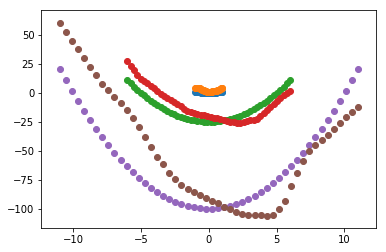

In [9]:
n_test = 500
for x in [0, 5, 10]:
    t = np.linspace(-x-1, x+1)
    y_true = t * t - x * x
    y_pred = boot_est.predict(t, np.full_like(t, x))
    plt.scatter(t, y_true, label='true y, x={0}'.format(x))
    plt.scatter(t, y_pred, label='pred y, x={0}'.format(x))

You can see that despite the fact that the response surface varies with x, our model was able to fit the data reasonably well.